In [1]:
import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset

/Users/anurag/Desktop/Self/Coding Projects/financial-sentiment-analysis/fin-sen-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset
This dataset contains a collection of finance-related tweets labelled for sentiment classification. Each tweet is annotated as either positive, neutral, or negative, reflecting the tweet's tone in the context of financial markets. The data is sourced from public Twitter posts.

When using this dataset with Hugging Face models, predictions are returned in the format `LABEL_0`, `LABEL_1`, and `LABEL_2`. These model-generated labels correspond to the following sentiment classes:

```python
sentiments = {
    "LABEL_0": "Bearish",
    "LABEL_1": "Bullish",
    "LABEL_2": "Neutral"
}
```

This mapping allows model outputs to be interpreted in the context of market sentiment, where:
- `Bearish` indicates a negative or pessimistic outlook,
- `Bullish` indicates a positive or optimistic outlook, and
- `Neutral` reflects an informational or non-directional tone.

In [4]:
dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9543
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2388
    })
})

In [11]:
df = pd.DataFrame(dataset["train"])
df

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0
...,...,...
9538,The Week's Gainers and Losers on the Stoxx Eur...,2
9539,Tupperware Brands among consumer gainers; Unil...,2
9540,vTv Therapeutics leads healthcare gainers; Myo...,2
9541,"WORK, XPO, PYX and AMKR among after hour movers",2


Straight away we can see that the labels are numerical, and the text associated seems to be slightly messy, and also have multiple ticker symbols. The first goal is to add more readability to the dataset.

## Sentiment Spreads

In [12]:
sentiments = {
    0: "bearish", 
    1: "bullish", 
    2: "neutral"
}  
df['label_str'] = df['label'].map(sentiments) # new column for readability

In [13]:
label_counts = df['label'].value_counts()
label_percentage = df['label'].value_counts(normalize=True) * 100.

print(label_counts.to_frame(), "\n\n", label_percentage.to_frame())

       count
label       
2       6178
1       1923
0       1442 

        proportion
label            
2       64.738552
1       20.150896
0       15.110552


## Frequency of classes
We can create a bar plot to obtain a visual of the spread of sentiments, even though above we can see that the neutral label makes up more than half the dataset.

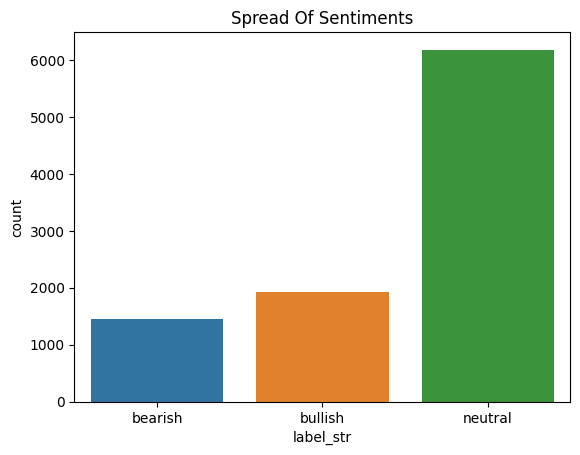

In [20]:
sns.countplot(x='label_str', data=df, hue='label_str', legend=False)
plt.title("Spread Of Sentiments")
plt.show()

We can see that the dataset is **heavily skewed** toward neutral tweets. Specifically, neutral labels make up around **65%** of the total data, which could lead to class imbalance issues during model training.

This imbalance may cause the model to favour the neutral class, so it'll be beneficial to consider **class weighting** and **resampling** as they might be necessary to improve performance on minority classes.